# Taller II (Deteccion de objetos)
* Guzman Huamani, Kevin Maycol 
* Londono ,Jose Schneider

# Import libraries 

In [1]:
%%capture
%pip install torchsummary

In [2]:
from __future__ import print_function, division

import numpy as np 
import pandas as pd 
from numpy.typing import NDArray
from functools import reduce
from itertools import islice
import wandb
import math
from itertools import chain
import copy

import torch
from torch import nn
from torch import Tensor
from torch.optim import Optimizer
import torch.nn.functional as F
import torchvision 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
import albumentations as A

from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

import os
import torch
import os.path as osp
from skimage import io, transform
import matplotlib.pyplot as plt
import typing as ty
import cv2

plt.ion()   # interactive mode

for root, dirs, filenames in os.walk('/kaggle/input'):
    for i, filepath in enumerate(filenames):
        if i >= 10:
            print()
            break
        print(osp.join(root, filepath))

/kaggle/input/af-ii-2023-i-object-localization/sample_submission.csv
/kaggle/input/af-ii-2023-i-object-localization/train.csv
/kaggle/input/af-ii-2023-i-object-localization/test.csv
/kaggle/input/af-ii-2023-i-object-localization/images/img_160.jpg
/kaggle/input/af-ii-2023-i-object-localization/images/img_21.jpg
/kaggle/input/af-ii-2023-i-object-localization/images/img_163.jpg
/kaggle/input/af-ii-2023-i-object-localization/images/img_151.jpg
/kaggle/input/af-ii-2023-i-object-localization/images/img_166.jpg
/kaggle/input/af-ii-2023-i-object-localization/images/img_53.jpg
/kaggle/input/af-ii-2023-i-object-localization/images/img_140.jpg
/kaggle/input/af-ii-2023-i-object-localization/images/img_91.jpg
/kaggle/input/af-ii-2023-i-object-localization/images/img_57.jpg
/kaggle/input/af-ii-2023-i-object-localization/images/img_137.jpg



In [3]:
import torchvision.transforms.functional as fn

## Creating dataset structure

In [4]:
torch.manual_seed(32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')
torch.cuda.empty_cache()

Using cuda


This is done in order to control randomness.

In [5]:
RANDOM_SEED = 30

In [6]:
DATA_DIR = '/kaggle/input/af-ii-2023-i-object-localization'
WORK_DIR = '/kaggle/working'
BATCH_SIZE = 32

img_dir = osp.join(DATA_DIR, "images")
h, w, c = 227, 227, 3 

obj2id = {
    "cucumber": 0, 
    "eggplant": 1,
    "mushroom": 2
}

id2obj = {
    0: "cucumber", 
    1: "eggplant",
    2: "mushroom"
}

df = pd.read_csv(osp.join(DATA_DIR, "train.csv"))
df["class_id"] = df["class"].map(obj2id)

df[["xmin", "ymin", "xmax", "ymax"]] /= h

train_df, val_df = train_test_split(
    df, stratify=df['class_id'], test_size=0.25#, random_state=RANDOM_SEED
)

print(train_df.shape)
print(val_df.shape)

test = pd.read_csv(osp.join(DATA_DIR, "test.csv"))

os.listdir(DATA_DIR)

(93, 7)
(31, 7)


['sample_submission.csv', 'images', 'train.csv', 'test.csv']

In [7]:
classes = df["class"].unique()
classes

array(['cucumber', 'eggplant', 'mushroom'], dtype=object)

In [8]:
df.head()

,filename,class,xmin,ymin,xmax,ymax,class_id
0,img_175.jpg,cucumber,0.154185,0.312775,0.867841,0.757709,0
1,img_16.jpg,cucumber,0.030837,0.074890,0.969163,0.876652,0
2,img_107.jpg,cucumber,0.070485,0.361233,0.916300,0.757709,0
3,img_31.jpg,cucumber,0.052863,0.207048,0.955947,0.594714,0
4,img_164.jpg,eggplant,0.246696,0.374449,0.753304,0.801762,1


In [9]:
test.head()

,filename
0,img_32.jpg
1,img_171.jpg
2,img_126.jpg
3,img_143.jpg
4,img_9.jpg


In [10]:
# shows the frequencies of each class
train_df['class'].value_counts(1) * 100

eggplant    33.333333
mushroom    33.333333
cucumber    33.333333
Name: class, dtype: float64

In [11]:
transform_func_inp_signature = ty.Dict[str, NDArray[np.float_]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class VegetableDataset(Dataset):
    def __init__(
        self, 
        df: pd.DataFrame, 
        root_dir: str, 
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx: int) -> transform_func_signature: 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Read image
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        image = io.imread(img_name)
        
        # Convert from BGR to RGB
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        sample = {'image': image}
        
        if self.labeled:
            # Read labels
            img_class = self.df.class_id.iloc[idx]
            #name_class = self.df['class'].iloc[idx]
            img_bbox = self.df.iloc[idx, 2:6]

            img_bbox = np.array([img_bbox]).astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})#,'name_class':name_class
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [12]:
def draw_bbox(img, bbox, color):
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    return img

def normalize_bbox(bbox, factor: int = 227):
    return list(map(lambda x: int(x * factor), bbox))

def draw_bboxes(imgs, bboxes, colors):
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color)
    return imgs

def draw_classes(imgs, classes, colors, origin, offset: int = 5, prefix: str =''):
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)): 
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX, 
            0.4, color, 1, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs, classes, bboxes, colors, origin):
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors)
    imgs = draw_classes(imgs, classes, colors, origin)
    return imgs

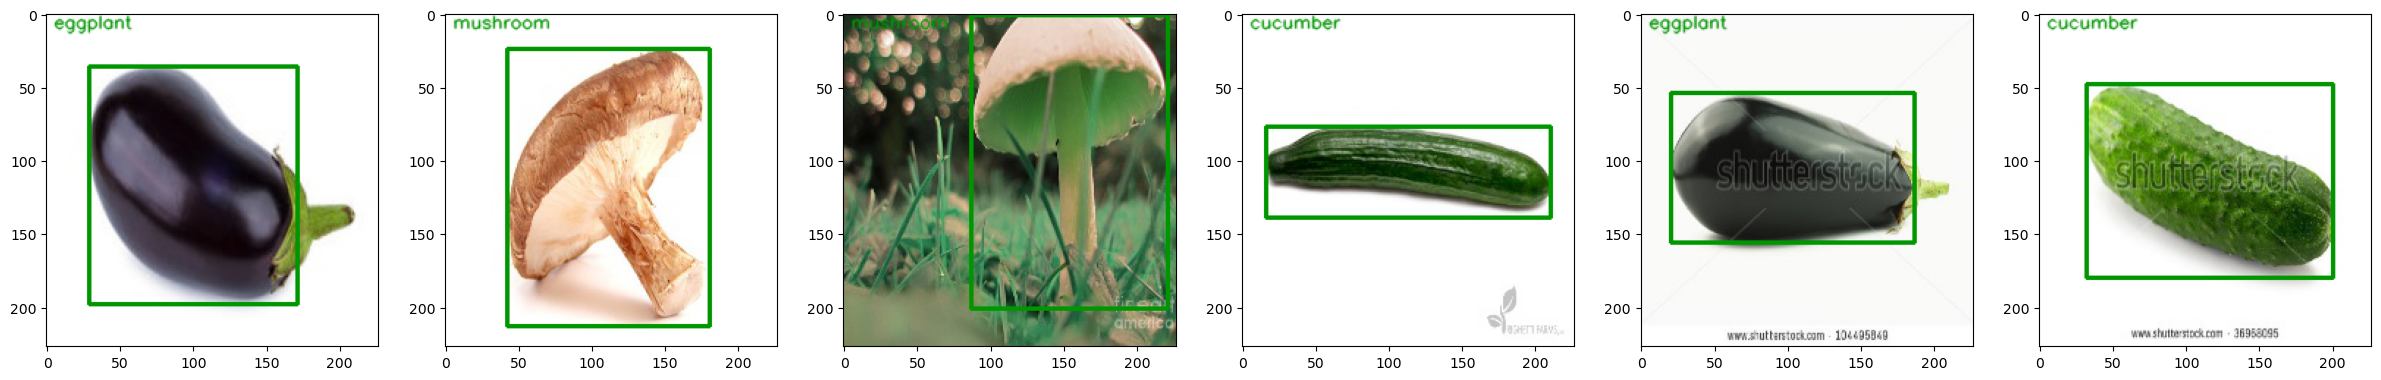

In [13]:
train_root_dir = osp.join(DATA_DIR, "images")#, "train"
train_ds = VegetableDataset(train_df, root_dir=train_root_dir)

num_imgs = 6
start_idx = 0

samples = [train_ds[i] for i in range(start_idx, num_imgs)]

imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]
classes = [s['class_id'] for s in samples]

imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (5, 10))#(150, 10)

fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

plt.show()

# Transfer learning

Four models:

The first one uses VGG19 as a backbone and applies custom convolutional layers with batch normalization and dropout.

The second one doesn't use any pre-trained model; only custom layers are applied.

The third one uses VGG16 as a backbone and applies custom convolutional layers with batch normalization and dropout. It uses different output kernels, dropout probabilities, and batch normalization.

The fourth one uses ResNet50 as a backbone and applies custom convolutional layers with batch normalization and dropout. It also uses different output kernels, dropout probabilities, and batch normalization.

**To use any backbone, uncomment the cell with Ctrl + Shift + / in this notebook. However, we will use the VGG19 backbone since it showed better results.**


In [14]:
from torchvision.models import vgg19


class ExtendedFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(ExtendedFeatureExtractor, self).__init__()
        # Extract VGG-19 Feature Layers
        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        # Extract VGG-19 Average Pooling Layer
        self.pooling = model.avgpool
        # Add a convolutional layer with batch normalization, dropout, and max pooling
        self.conv = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.batch_norm = nn.BatchNorm2d(num_features=1024)
        self.conv_dropout = nn.Dropout(0.5)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        # Convert the image into one-dimensional vector
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
  
    def forward(self, x):
        # Pass input through VGG-19 feature layers and average pooling layer
        out = self.features(x)
        out = self.pooling(out)
        # Pass output through additional convolutional layer with batch normalization, dropout, and max pooling
        out = self.conv(out)
        out = F.relu(out)
        out = self.batch_norm(out)
        out = self.conv_dropout(out)
        out = self.max_pool(out)
        # Flatten output and apply dropout
        out = self.flatten(out)
        out = self.dropout(out) 
        return out 

# Load the vgg19 model
vgg19_model = vgg19(pretrained=True, progress=True)
pretrained_model = ExtendedFeatureExtractor(vgg19_model).to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [15]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         # First convolutional block
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.batch_norm1 = nn.BatchNorm2d(num_features=32)
#         self.conv_dropout1 = nn.Dropout(0.3)
#         self.max_pool1 = nn.MaxPool2d(kernel_size=2)
#         # Second convolutional block
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.batch_norm2 = nn.BatchNorm2d(num_features=64)
#         self.conv_dropout2 = nn.Dropout(0.3)
#         self.max_pool2 = nn.MaxPool2d(kernel_size=2)
#         # Third convolutional block
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.batch_norm3 = nn.BatchNorm2d(num_features=128)
#         self.conv_dropout3 = nn.Dropout(0.3)
#         self.max_pool3 = nn.MaxPool2d(kernel_size=2)
#         # Flatten output
#         self.flatten = nn.Flatten()

  
#     def forward(self, x):
#         # Pass input through first convolutional block
#         out = self.conv1(x)
#         out = F.relu(out)
#         out = self.batch_norm1(out)
#         out = self.conv_dropout1(out)
#         out = self.max_pool1(out)
#         # Pass output through second convolutional block
#         out = self.conv2(out)
#         out = F.relu(out)
#         out = self.batch_norm2(out)
#         out = self.conv_dropout2(out)
#         out = self.max_pool2(out)
#         # Pass output through third convolutional block
#         out = self.conv3(out)
#         out = F.relu(out)
#         out = self.batch_norm3(out)
#         out = self.conv_dropout3(out)
#         out = self.max_pool3(out)

#         # Flatten output
#         out = self.flatten(out) 
        
#         return out 

# pretrained_model = ConvNet().to(device) 

In [16]:
# from torchvision.models import vgg16

# class FeatureExtractor(nn.Module):
#     def __init__(self, model):
#         super(FeatureExtractor, self).__init__()
#         # Extract VGG-16 Feature Layers
#         self.features = list(model.features)
#         self.features = nn.Sequential(*self.features)
#         # Extract VGG-16 Average Pooling Layer
#         self.pooling = model.avgpool
#         # Add a convolutional layer with batch normalization, dropout, and max pooling
#         self.conv = nn.Conv2d(in_channels=512, out_channels=800, kernel_size=4, padding=1)
#         self.batch_norm = nn.BatchNorm2d(num_features=800)
#         self.conv_dropout = nn.Dropout(0.7)
#         self.max_pool = nn.MaxPool2d(kernel_size=2)
#         # Convert the image into one-dimensional vector
#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(0.5)
  
#     def forward(self, x):
#         # Pass input through VGG-16 feature layers and average pooling layer
#         out = self.features(x)
#         out = self.pooling(out)
#         # Pass output through additional convolutional layer with batch normalization, dropout, and max pooling
#         out = self.conv(out)
#         out = F.relu(out)
#         out = self.batch_norm(out)
#         out = self.max_pool(out)
#         # Flatten output and apply dropout
#         out = self.flatten(out)
#         out = self.dropout(out) 
#         return out 

# # Load the vgg16 model
# vgg16_model = vgg16(pretrained=True, progress=True)
# pretrained_model = FeatureExtractor(vgg16_model).to(device)
# pretrained_model

In [17]:
# from torchvision.models import resnet50

# class ExtendedFeatureExtractor(nn.Module):
#     def __init__(self, model):
#         super(ExtendedFeatureExtractor, self).__init__()
#         # Extract ResNet-50 Feature Layers
#         self.features = nn.Sequential(*list(model.children())[:-2])
#         # Add a convolutional layer with batch normalization, dropout, and max pooling
#         self.conv = nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=3, padding=1)
#         self.batch_norm = nn.BatchNorm2d(num_features=1024)
#         self.conv_dropout = nn.Dropout(0.5)
#         self.max_pool = nn.MaxPool2d(kernel_size=2)
#         # Convert the image into one-dimensional vector
#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(0.5)
  
#     def forward(self, x):
#         # Pass input through ResNet-50 feature layers
#         out = self.features(x)
#         # Pass output through additional convolutional layer with batch normalization, dropout, and max pooling
#         out = self.conv(out)
#         out = F.relu(out)
#         out = self.batch_norm(out)
#         out = self.conv_dropout(out)
#         out = self.max_pool(out)
#         # Flatten output and apply dropout
#         out = self.flatten(out)
#         out = self.dropout(out) 
#         return out 

# # Load the resnet50 model
# resnet50_model = resnet50(pretrained=True, progress=True)
# pretrained_model = ExtendedFeatureExtractor(resnet50_model).to(device)

In [18]:
summary(pretrained_model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 227, 227]           1,792
              ReLU-2         [-1, 64, 227, 227]               0
            Conv2d-3         [-1, 64, 227, 227]          36,928
              ReLU-4         [-1, 64, 227, 227]               0
         MaxPool2d-5         [-1, 64, 113, 113]               0
            Conv2d-6        [-1, 128, 113, 113]          73,856
              ReLU-7        [-1, 128, 113, 113]               0
            Conv2d-8        [-1, 128, 113, 113]         147,584
              ReLU-9        [-1, 128, 113, 113]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Image normalization

In [19]:
train_ds = VegetableDataset(train_df, root_dir=train_root_dir)

means = None 
stds = None 

if means is None and stds is None:
    means, stds = [], []
    pixel_values = [
        [], # R, size = H * W * num_images 
        [], # G size = H * W * num_images
        [], # B size = H * W * num_images
    ]

    for x in train_ds:
        img = x['image']

        for channel in range(3):
            channel_pixel_values = list(img[..., channel].flatten())
            pixel_values[channel].extend(channel_pixel_values)

    for channel in range(3):
        means.append(np.mean(pixel_values[channel]))
        stds.append(np.std(pixel_values[channel]))
    
    del pixel_values

In [20]:
print(means)
print(stds)

[195.10712143094284, 192.7739711034417, 181.50870675809028]
[81.07411199833996, 82.08159479076939, 91.8565886873944]


# Image transforms

A recommended library to do image augmentation is https://albumentations.ai/docs/examples/pytorch_classification/


In [21]:
class ToTensor(object):
    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
        sample.update({'image': image})
        return sample

class Normalizer(object):
    
    def __init__(self, stds, means):
        self.stds = stds
        self.means = means
    
    def __call__(self, sample):
        image = sample['image']
        
        for channel in range(3):
            image[channel] = (image[channel] - means[channel]) / stds[channel]

        sample['image'] = image
        return sample

class TVTransformWrapper(object):
    def __init__(self, transform: torch.nn.Module):
        self.transform = transform
        
    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample

class AlbumentationsWrapper(object):
    
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, sample):
        transformed = self.transform(
            image=sample['image'], 
            bboxes=sample['bbox'],
            #category_ids=sample['class_id']
        )
        sample['image'] = transformed['image']
        sample['bbox'] = np.array(transformed['bboxes'])
        return sample

In [22]:
common_transforms = [    
    ToTensor(),
    Normalizer(
        means=means,
        stds=stds,
    )
]

# data augmentations composicion personalizada:
train_data_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.01, p=1),
    A.ImageCompression(p=1),
    # A.Rotate(limit=(-10,10), p=0.5),
    A.Affine(translate_percent={'x':(-0.10, 0.10),'y':(-0.10, 0.10)}, p=0.5),
    A.Resize(height=227, width=227, p=1), # p=1 means always apply
    A.RandomBrightnessContrast(p=0.7, brightness_limit=0.02, contrast_limit=0.02),
    A.Blur(p=0.5, blur_limit=1),
    A.ColorJitter(p=0.5, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # A.Downscale(p=1, scale_min=0.5, scale_max=0.75),
    A.FancyPCA(p=1),
    A.GaussianBlur(p=0.5),
    A.GridDistortion(p=0.5),
    # A.ISONoise(p=1),
    A.IAAPerspective(p=0.5),
    ],
    bbox_params=A.BboxParams(
        format='albumentations', 
        label_fields=[],#'category_ids'
    )
)

train_transforms = torchvision.transforms.Compose(
    [
        AlbumentationsWrapper(train_data_augmentations),
    ] + common_transforms
)

eval_transforms = torchvision.transforms.Compose(common_transforms)

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)


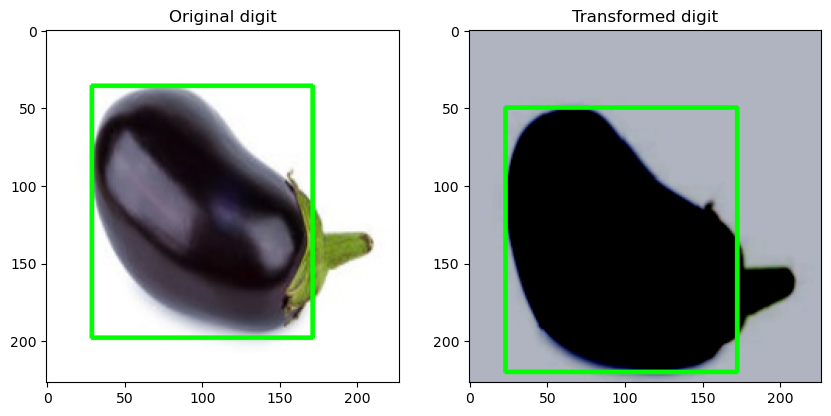

In [23]:
train_ds = VegetableDataset(train_df, root_dir=train_root_dir)

x = next(iter(train_ds))
x_transformed = copy.deepcopy(x)
x_transformed = train_transforms(x_transformed)

original_img = x['image']
transformed_img = x_transformed['image'].numpy().transpose(1, 2, 0)

original_img = draw_bbox(
    original_img,
    normalize_bbox(x['bbox'].squeeze()),
    (0, 255, 0)
)

transformed_img = draw_bbox(
    transformed_img,
    normalize_bbox(x_transformed['bbox'].squeeze()),
    (0, 255, 0)
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(original_img)
axes[0].set_title('Original digit')

axes[1].imshow(transformed_img)
axes[1].set_title('Transformed digit')

plt.show()

In [24]:
train_ds = VegetableDataset(df, root_dir=train_root_dir, transform=train_transforms)
train_data = torch.utils.data.DataLoader(train_ds, batch_size=32)

for x in train_data:
    print(x['image'].size())
    break


torch.Size([32, 3, 227, 227])


In [25]:
def get_output_shape(model: nn.Sequential, image_dim: ty.Tuple[int, int, int]):
    return model(torch.rand(*(image_dim)).to(device)).data.shape

class Model(nn.Module):
    def __init__(self, input_shape: ty.Tuple[int, int, int] = (3, 227, 227), n_classes: int = 3):
        super().__init__()
        
        self.input_shape = input_shape
        
        # pretrained model with own personalized CNN as backbone
        self.backbone = pretrained_model
        
        backbone_output_shape = get_output_shape(self.backbone, [1, *input_shape])
        backbone_output_features = reduce(lambda x, y: x*y, backbone_output_shape)
        
        # simple classification head
        self.cls_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )
        # simple regression head 
        self.reg_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x: Tensor) -> ty.Dict[str, Tensor]:
        features = self.backbone(x)
        cls_logits = self.cls_head(features)
        pred_bbox = self.reg_head(features)
        predictions = {'bbox': pred_bbox, 'class_id': cls_logits}
        return predictions

In [26]:
torch.cuda.empty_cache()

# Metrics

In [28]:
def iou(y_true: Tensor, y_pred: Tensor):
    pairwise_iou = torchvision.ops.box_iou(y_true.squeeze(), y_pred.squeeze())
    result = torch.trace(pairwise_iou) / pairwise_iou.size()[0]
    return result

In [29]:
def accuracy(y_true: Tensor, y_pred: Tensor):
    pred = torch.argmax(y_pred, axis=-1)
    y_true = y_true.squeeze()
    correct = torch.eq(pred, y_true).float()
    total = torch.ones_like(correct)
    result = torch.divide(torch.sum(correct), torch.sum(total))
    return result

# Loss fn

In [30]:
def loss_fn(y_true, y_preds, alpha: float = 0.5):
    cls_y_true, cls_y_pred = y_true['class_id'].long(), y_preds['class_id'].float().unsqueeze(-1)
    reg_y_true, reg_y_pred = y_true['bbox'].float().squeeze(), y_preds['bbox'].float().squeeze()
    
    cls_loss = F.cross_entropy(cls_y_pred, cls_y_true)
    
    reg_loss = F.mse_loss(reg_y_pred, reg_y_true)
    # Adds weights to both tasks
    total_loss = (1 - alpha) * cls_loss + alpha * reg_loss
    return dict(loss=total_loss, reg_loss=reg_loss,cls_loss=cls_loss)

# Callbacks

In [31]:
def printer(logs: ty.Dict[str, ty.Any]):
    # print every 10 steps
    if logs['iters'] % 10 != 0:
        return
    print('Iteration #: ',logs['iters'])
    for name, value in logs.items():
        if name == 'iters':
            continue
        
        if type(value) in [float, int]:
            value = round(value, 4)
        elif type(value) is torch.Tensor:
            value = torch.round(value, decimals=4)
        
        print(f'\t{name} = {value}')
    print()

# Training loop

In [32]:
def evaluate(
    logs: ty.Dict[str, ty.Any], 
    labels: ty.Dict[str, Tensor],
    preds: ty.Dict[str, Tensor],
    eval_set: str,
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    losses: ty.Optional[ty.Dict[str, Tensor]] = None,
) -> ty.Dict[str, ty.Any]:
    
    if losses is not None:
        for loss_name, loss_value in losses.items():
            logs[f'{eval_set}_{loss_name}'] = loss_value
    
    for task_name, label in labels.items():
        for metric_name, metric in metrics[task_name]:
            value = metric(label, preds[task_name])
            logs[f'{eval_set}_{metric_name}'] = value
            
    return logs

def step(
    model: Model, 
    optimizer: Optimizer, 
    batch: VegetableDataset,
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    device: str,
    train: bool = False,
) -> ty.Tuple[ty.Dict[str, Tensor], ty.Dict[str, Tensor]]:
    
    if train:
        optimizer.zero_grad()
    
    img = batch.pop('image').to(device)
    
    for k in list(batch.keys()):
        batch[k] = batch[k].to(device)
    
    preds = model(img.float())
    losses = loss_fn(batch, preds)
    final_loss = losses['loss']
    
    if train:
        final_loss.backward()
        optimizer.step()
    
    return losses, preds


def train(
    model: Model, 
    optimizer: Optimizer, 
    dataset: DataLoader,
    eval_datasets: ty.List[ty.Tuple[str, DataLoader]],
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    callbacks: ty.List[ty.Callable[[ty.Dict[ty.Any, ty.Any]], None]],
    device: str,
    train_steps: 100,
    eval_steps: 10,
) -> Model:
    # Send model to device (GPU or CPU)
    model = model.to(device)
    iters = 0
    iterator = iter(dataset)
    assert train_steps > eval_steps, 'Train steps should be greater than the eval steps'
    
    while iters <= train_steps:
        logs = dict()
        logs['iters'] = iters
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(dataset)
            batch = next(iterator)
        # Send batch to device 
        losses, preds = step(model, optimizer, batch, loss_fn, device, train=True)
        logs = evaluate(logs, batch, preds, 'train', metrics, losses)
        
        # Eval every eval_steps iterations
        if iters % eval_steps == 0:        
            # Evaluate
            # Deactives layers that only needed to train
            # https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615
            model.eval()
            
            # Avoids calculating gradients in evaluation dataset. 
            with torch.no_grad():

                for name, dataset in eval_datasets:
                    for batch in dataset:
                        losses, preds = step(model, optimizer, batch, loss_fn, device, train=False)            
                        logs = evaluate(logs, batch, preds, name, metrics, losses)
        
        for callback in callbacks:
            callback(logs)
        
        iters += 1
    
    return model

# Run

In [33]:
# Hparams
batch_size = 128
lr = 0.0001

# Data
train_ds = VegetableDataset(train_df, root_dir=train_root_dir, transform=train_transforms)
val_ds = VegetableDataset(val_df, root_dir=train_root_dir, transform=eval_transforms)

train_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=cpu_count())
val_data = DataLoader(val_ds, batch_size=batch_size, num_workers=cpu_count())

# Model
model = Model().to(device)
summary(model, model.input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 227, 227]           1,792
              ReLU-2         [-1, 64, 227, 227]               0
            Conv2d-3         [-1, 64, 227, 227]          36,928
              ReLU-4         [-1, 64, 227, 227]               0
         MaxPool2d-5         [-1, 64, 113, 113]               0
            Conv2d-6        [-1, 128, 113, 113]          73,856
              ReLU-7        [-1, 128, 113, 113]               0
            Conv2d-8        [-1, 128, 113, 113]         147,584
              ReLU-9        [-1, 128, 113, 113]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [34]:
# Optimizer
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=250,
    eval_steps=10
)

Iteration #:  0
	train_loss = 0.7788000106811523
	train_reg_loss = 0.39579999446868896
	train_cls_loss = 1.1618000268936157
	train_iou = 0.0
	train_accuracy = 0.32260000705718994
	val_loss = 0.6341999769210815
	val_reg_loss = 0.23270000517368317
	val_cls_loss = 1.0356999635696411
	val_iou = 0.0
	val_accuracy = 0.6773999929428101

Iteration #:  10
	train_loss = 0.04149999842047691
	train_reg_loss = 0.0828000009059906
	train_cls_loss = 0.00019999999494757503
	train_iou = 0.3183
	train_accuracy = 1.0
	val_loss = 0.02810000069439411
	val_reg_loss = 0.05609999969601631
	val_cls_loss = 9.999999747378752e-05
	val_iou = 0.3559
	val_accuracy = 1.0

Iteration #:  20
	train_loss = 0.005100000184029341
	train_reg_loss = 0.010099999606609344
	train_cls_loss = 0.0
	train_iou = 0.5834
	train_accuracy = 1.0
	val_loss = 0.0035000001080334187
	val_reg_loss = 0.007000000216066837
	val_cls_loss = 0.0
	val_iou = 0.6323
	val_accuracy = 1.0

Iteration #:  30
	train_loss = 0.0017999999690800905
	train_reg_los

In [35]:
num_imgs = 5
ncols = 5
nrows = math.ceil(num_imgs / ncols)

start_idx = 0

inference_ds = VegetableDataset(val_df.iloc[start_idx:start_idx+num_imgs], root_dir=train_root_dir)
inference_data = DataLoader(inference_ds, batch_size=num_imgs, num_workers=1, shuffle=False)
inference_batch = next(iter(inference_data))
inference_imgs = np.empty((num_imgs, 3, 227, 227))

transform = eval_transforms

for i, img in enumerate(inference_batch['image']):
    inference_imgs[i] = transform(dict(image=img.numpy()))['image'].numpy()

preds = model(torch.tensor(inference_imgs).float().to(device))

samples = [inference_ds[i] for i in range(start_idx, num_imgs)]

imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]
classes = [s['class_id'] for s in samples]

pred_bboxes = preds['bbox'].detach().cpu().numpy()
pred_bboxes = [normalize_bbox(bbox) for bbox in pred_bboxes]
pred_classes = preds['class_id'].argmax(-1).detach().cpu().numpy()

In [36]:
inference_imgs.shape

(5, 3, 227, 227)

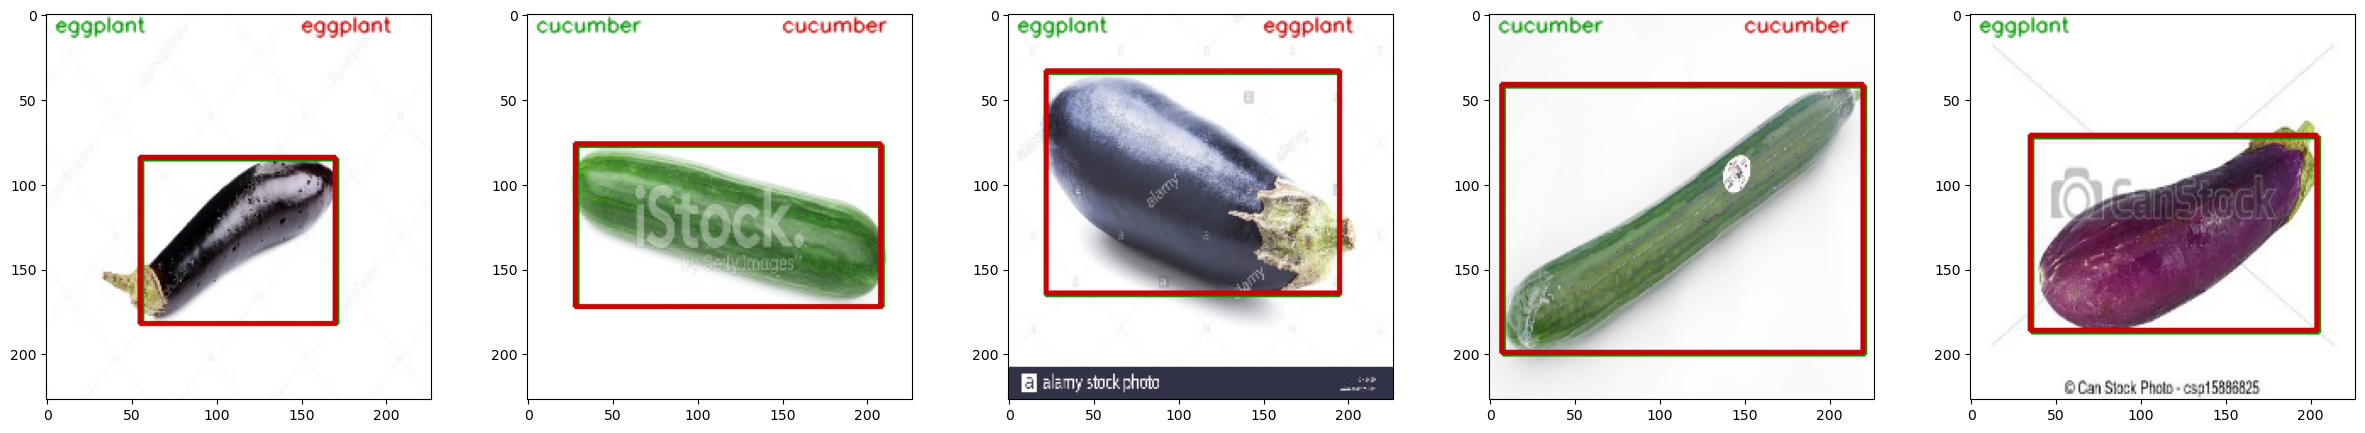

In [37]:
# Green: ground truth
imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (5, 10))
# Red: predicted

pred_classes_=[]
for i in range(0,num_imgs-1):
    temp=np.array([pred_classes[i]])
    pred_classes_.append(temp)
imgs = draw_predictions(imgs, pred_classes_, pred_bboxes, [(200, 0, 0)], (150, 10))

fig = plt.figure(figsize=(30*nrows, num_imgs))
k, j = 1, 1

for img in imgs:
    if j > ncols and k < nrows:
        k += 1
        j = 1
    fig.add_subplot(k, num_imgs, j)
    plt.imshow(img)
    j += 1

plt.show()

In [38]:
# Save the model to disk
torch.save(model, 'pretrained_model.pth')

# Submission

In [39]:
# Perform inference on cpu in order to avoid memory problems 
device = 'cuda'
model = model.to(device)

test_root_dir = osp.join(DATA_DIR, "images")
test_df = pd.read_csv(osp.join(DATA_DIR, "test.csv"))

test_ds = VegetableDataset(test_df, root_dir=test_root_dir, labeled=False, transform=eval_transforms)
test_data = DataLoader(test_ds, batch_size=1, num_workers=cpu_count(), shuffle=False)

class_preds = []
bbox_preds = []

for batch in test_data:
    batch_preds = model(batch['image'].float().to(device))
    
    class_pred = batch_preds['class_id'].argmax(-1).detach().cpu().numpy()
    bbox_pred = batch_preds['bbox'].detach().cpu().numpy()
    
    class_preds.append(class_pred.squeeze())
    bbox_preds.append(bbox_pred.squeeze())

In [40]:
class_preds = np.array(class_preds)
bbox_preds = np.array(bbox_preds)

In [44]:
submission = pd.DataFrame(
    index=test_df.filename,
    data={
        'class': class_preds,
        'x1': bbox_preds[:, 0],
        'y1': bbox_preds[:, 1],
        'x2': bbox_preds[:, 2],
        'y2': bbox_preds[:, 3]
    }
)

submission['class'] = submission['class'].apply(lambda x: id2obj[x])
submission

,class,x1,y1,x2,y2
filename,,,,,
img_32.jpg,cucumber,0.097773,0.298057,0.991291,0.732834
img_171.jpg,mushroom,0.176328,0.200653,0.637776,0.684008
img_126.jpg,cucumber,0.019544,0.188464,0.697240,0.589639
img_143.jpg,cucumber,0.166558,0.291901,0.823097,0.716062
img_9.jpg,mushroom,0.224775,0.151129,0.584666,0.642667
...,...,...,...,...,...
img_53.jpg,eggplant,0.147162,0.190844,0.814315,0.707812
img_132.jpg,eggplant,0.077512,0.160471,0.710994,0.704138
img_125.jpg,eggplant,0.132814,0.177550,0.759156,0.713800


In [42]:
submission.to_csv('submission.csv')